# Blobs classification implementation

In [2]:
import torch
import sklearn
import matplotlib.pyplot as plt
import numpy as np

### Device / dtypes settings

In [88]:
params = {}

if torch.cuda.is_available():
    params['device'] = torch.device('cuda', 0)
else:
    params['device'] = torch.device('cpu')

params['dtypes'] = {'X': np.float32, 'y': np.int64}

params['n_epochs'] = 20

params['train_batch_size'] = 50

params['n_hidden_layers'] = 20
params['hidden_layers_size'] = 20

params

{'device': device(type='cuda', index=0),
 'dtypes': {'X': numpy.float32, 'y': numpy.int64},
 'n_epochs': 20,
 'train_batch_size': 50,
 'n_hidden_layers': 20,
 'hidden_layers_size': 20}

## Dataset

In [5]:
def generate_dataset() -> None:
    import sklearn.datasets
    import sklearn.model_selection
    
    X, y = sklearn.datasets.make_blobs(
        n_samples=20_000,
        centers=6,
        cluster_std=1.1,
        random_state=0
    )

    # generate a downsampling mask for each class to a given amount
    y_probs = y.copy().astype('f4')
    y_probs[y_probs == 0] = 0.99
    y_probs[y_probs == 1] = 0.1
    y_probs[y_probs == 2] = 0.5
    y_probs[y_probs == 3] = 0.4
    y_probs[y_probs == 4] = 0.9
    y_probs[y_probs == 5] = 0.2

    mask = (
        torch.bernoulli(
            torch.from_numpy(y_probs)
            .to(torch.float32))
        .to(torch.bool)
        .numpy()
    )

    # merge some classes
    #y[y == 3] = 1
    y[y == 2] = 5
    y[y == 4] = 0

    # downsample
    X = X[mask, :]
    y = y[mask]

    
    # split to train and test
    (
        X_train, 
        X_test, 
        y_train, 
        y_test
    ) = sklearn.model_selection.train_test_split(
        X, 
        y, 
        train_size = 0.6
    )
    
    return (
        X_train, 
        X_test, 
        y_train, 
        y_test
    )
    
(
    X_train, 
    X_test, 
    y_train, 
    y_test
) = generate_dataset()

In [5]:
X_train[:10, :], y_train[:10], np.unique(y_train, return_counts=True)

(array([[-0.0567687 ,  2.21874876],
        [ 0.64506581,  4.89447403],
        [ 0.19755846,  8.13212751],
        [ 1.88417953,  3.97563184],
        [ 8.99906633, -1.75564326],
        [ 0.09879704,  4.82009678],
        [-1.81481978,  8.54338529],
        [-1.68573608,  6.89480947],
        [-2.60315013,  3.97418014],
        [ 8.380942  , -1.42722243]]),
 array([5, 0, 3, 0, 0, 0, 3, 3, 5, 0]),
 (array([0, 1, 3, 5]), array([3810,  225,  828, 1372])))

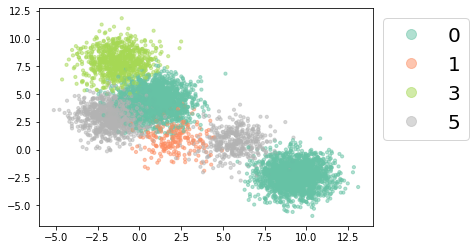

In [6]:
fig = plt.figure(1)
ax = fig.add_subplot()
pl1 = ax.scatter(*X_train.T, c=y_train, cmap='Set2', s=10, alpha = 0.5)
_ = ax.legend(
    *pl1.legend_elements(prop='colors', size=10),
    bbox_to_anchor=(1,1),
    fontsize=20
)   


## Setup the transformers

In [6]:

# the ordinal encoder must be fit and used to transform with a 2 d array (dim 0 being the observations)
y_ordinal_encoder = (
    sklearn
    .preprocessing
    .OrdinalEncoder()
    .fit(y_train[:, None])
)

X_standard_scaler = (
    sklearn
    .preprocessing
    .StandardScaler()
    .fit(X_train)
)

In [7]:
y_ordinal_encoder.transform(y_train[:, None]).squeeze() # need to add a dimension to fit, after that it has to be removed (squeezed)

array([3., 0., 0., ..., 0., 3., 0.])

In [8]:
X_standard_scaler.transform(X_train)

array([[-1.44376565,  0.26666917],
       [ 1.15977626, -1.57320509],
       [-0.28167677,  0.25993171],
       ...,
       [-0.36899056,  0.42400196],
       [ 0.56458888, -0.54543262],
       [ 1.25408993, -1.45231435]])

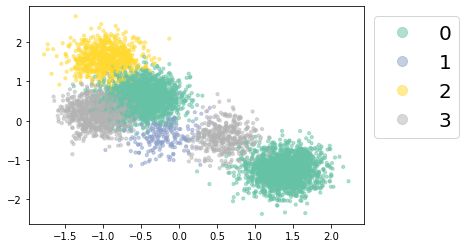

In [9]:
fig = plt.figure(1)
ax = fig.add_subplot()
pl1 = ax.scatter(
    *X_standard_scaler.transform(X_train).T,
    c=y_ordinal_encoder.transform(y_train[:, None]).squeeze(), 
    cmap='Set2', s=10, alpha = 0.5
)
_ = ax.legend(
    *pl1.legend_elements(prop='colors', size=10),
    bbox_to_anchor=(1,1),
    fontsize=20
)   


## Setup the dataset

In [10]:
class Dataset_(torch.utils.data.Dataset):
    def __init__(self, 
                 X, 
                 y, 
                 X_transformer = None, 
                 y_transformer = None, 
                 X_dtype = np.float32,
                 y_dtype = np.int64):
        
        import numpy as np
        self.X = X
        self.y = y
        self.X_transformer = X_transformer
        self.y_transformer = y_transformer
        self.n_items = X.shape[0]
        self.X_dtype = X_dtype
        self.y_dtype = y_dtype
        
        # setup the weights
        weights = y.copy().astype(np.float32) # has to be float because later weights (float) will be inserted here
        levels, counts = np.unique(y, return_counts = True)
        n_levels = len(levels)
        self.balanced_dataset_size = int(np.min(counts) * n_levels)
        average_weight = 1 / n_levels
        
        for level in levels:
            n_level = np.sum(y == level)
            level_proportion = n_level / self.n_items            
            level_weight = average_weight / level_proportion
            weights[weights == level] = level_weight
            
        self.weights = weights
        self.n_levels = n_levels
        
    def __getitem__(self, index):
        # deal with transformations if specified
        if self.X_transformer is not None:
            X = self.X[[index], :] # must be 2d [[1, 3]]
            X = self.X_transformer.transform(X)
            X = np.squeeze(X)
        else:
            X = self.X[index]
        if self.y_transformer is not None:
            y = np.array([[self.y[index]]]) # must be 2d [[0]]
            y = self.y_transformer.transform(y)
            y = np.squeeze(y)
        else:
            y = self.y[index]
            
        return X.astype(self.X_dtype), y.astype(self.y_dtype)
    
    def __len__(self):
        return self.n_items

In [11]:
train_dataset = Dataset_(
    X_train, 
    y_train, 
    X_standard_scaler, 
    y_ordinal_encoder,
    X_dtype = params['dtypes']['X'],
    y_dtype = params['dtypes']['y']
)

train_dataset[0]

(array([-1.4437656 ,  0.26666918], dtype=float32), array(3))

In [12]:
test_dataset = Dataset_(
    X_test, 
    y_test, 
    X_standard_scaler, 
    y_ordinal_encoder,
    X_dtype = params['dtypes']['X'],
    y_dtype = params['dtypes']['y']
)

test_dataset[0]

(array([ 0.41883054, -0.65536565], dtype=float32), array(3))

In [13]:
train_dataset.weights

array([1.1094203 , 0.40438458, 0.40438458, ..., 0.40438458, 1.1094203 ,
       0.40438458], dtype=float32)

In [14]:
train_dataset.balanced_dataset_size

808

In [15]:
# the Samplers are simple generators that provide a random set of indexes of the specified length
# for use in conjunction with DataLoader, it should be initialized specifiying the length of the 
# dataset, so, every iteration it will provide new shuffled indexes.
list(torch.utils.data.WeightedRandomSampler(train_dataset.weights, 5, replacement=False))

[5201, 1028, 506, 3215, 4384]

In [16]:
np.unique(
    y_train[list(torch.utils.data.WeightedRandomSampler(train_dataset.weights, len(train_dataset.weights), replacement=False))],
    return_counts = True
)

(array([0, 1, 3, 5]), array([3786,  202,  756, 1380]))

In [17]:
# if replacement is false, then there won't be any balancing between the classes
# one way around is to allow replacement like below, there the counts between 
# classes is homogeneous
np.unique(
    y_train[list(torch.utils.data.WeightedRandomSampler(train_dataset.weights, len(train_dataset.weights), replacement=True))],
    return_counts = True
)

(array([0, 1, 3, 5]), array([1566, 1495, 1542, 1521]))

In [18]:
# another alternative is to use the balanced_dataset_size in combination with no replacement
np.unique(
    y_train[list(torch.utils.data.WeightedRandomSampler(train_dataset.weights, train_dataset.balanced_dataset_size, replacement=False))],
    return_counts = True
)

(array([0, 1, 3, 5]), array([217, 146, 209, 236]))

In [80]:
train_dataloader = torch.utils.data.DataLoader(
    dataset = train_dataset, 
    batch_size = params['train_batch_size'] , 
    pin_memory = True,
#     pin_memory_device='cuda',
    sampler= (
        torch
        .utils
        .data
        .WeightedRandomSampler(
            train_dataset.weights, 
            num_samples = len(train_dataset.weights), # can also be same as batch_size
            #num_samples = train_dataset.balanced_dataset_size, # can also be same as batch_size
            replacement=False
        )
    )
)

In [81]:
test_dataloader = torch.utils.data.DataLoader(
    dataset = test_dataset, 
    batch_size=len(test_dataset), 
    pin_memory = True,
    #pin_memory_device=''
)

In [82]:
for i, (X_train_batch, y_train_batch) in enumerate(train_dataloader):
    if i < 4:
        print(
            f'X -> \n{X_train_batch[:10]}\n'
            f'{X_train_batch.device}\n'
            f'y -> \n{y_train_batch[:10]}\n'
            f'labels, label counts -> \n{np.unique(y_train_batch, return_counts = True)}\n\n'
        )

X -> 
tensor([[-0.2843, -0.4390],
        [-0.3639,  0.7436],
        [-0.1176, -0.6399],
        [-0.6674,  1.4335],
        [-1.1208,  1.5778],
        [ 1.2312, -1.3857],
        [-0.8948,  1.8968],
        [-0.1131, -0.2241],
        [-0.2134, -0.6344],
        [-1.3083,  1.6148]])
cpu
y -> 
tensor([1, 0, 1, 2, 2, 0, 2, 1, 1, 2])
labels, label counts -> 
(array([0, 1, 2, 3]), array([15, 10, 15, 10]))


X -> 
tensor([[ 2.0174, -1.2231],
        [-0.0665, -0.2155],
        [ 1.2421, -0.7368],
        [ 0.0941, -0.6571],
        [-0.3058, -0.9850],
        [-0.9152,  0.0131],
        [-1.3750,  1.1332],
        [-1.2270,  0.1815],
        [ 1.5696, -1.4382],
        [-1.0587,  1.8881]])
cpu
y -> 
tensor([0, 1, 0, 1, 1, 3, 2, 3, 0, 2])
labels, label counts -> 
(array([0, 1, 2, 3]), array([10, 11, 14, 15]))


X -> 
tensor([[-1.0208,  1.3137],
        [-0.2596, -0.0905],
        [-0.5603,  1.5407],
        [ 1.4254, -1.4065],
        [-0.1220, -0.1615],
        [ 0.0916, -0.4775],
      

In [83]:
for i, (X_test_batch, y_test_batch) in enumerate(test_dataloader):
    if i < 4:
        print(
            f'X -> \n{X_test_batch[:10]}\n'
            f'{X_test_batch.device}\n'
            f'y -> \n{y_test_batch[:10]}\n'
            f'labels, label counts -> \n{np.unique(y_test_batch, return_counts = True)}\n\n'
        )

X -> 
tensor([[ 0.4188, -0.6554],
        [-0.8185,  1.4459],
        [ 1.0578, -1.2267],
        [-0.2208,  1.0802],
        [ 1.7775, -0.7564],
        [-0.5650,  1.0091],
        [ 1.1056, -0.8303],
        [-0.3884,  0.6533],
        [ 1.2764, -1.5903],
        [ 1.7052, -0.8556]])
cpu
y -> 
tensor([3, 2, 0, 0, 0, 0, 0, 0, 0, 0])
labels, label counts -> 
(array([0, 1, 2, 3]), array([2504,  138,  525,  917]))




## Setup the model

In [84]:
# setup first the hidden layers
class HiddenLayers(torch.nn.Module):
    def __init__(self, hidden_layers_size):
        super(HiddenLayers, self).__init__()
        self.linear = torch.nn.Linear(
            in_features=hidden_layers_size, 
            out_features=hidden_layers_size
        )
        torch.nn.init.xavier_normal_(self.linear.weight)
        
    def forward(self, X):
        out = self.linear(X)
        out = torch.nn.functional.relu(out)
        out = out + X # skip connection method
        return out


# setup the full classifier
class BlobsClassifier(torch.nn.Module):
    def __init__(self, 
                 in_features = 2,
                 n_hidden_layers = 20, 
                 hidden_layers_size = 20,  
                 out_features = 4):
        
        super(BlobsClassifier, self).__init__()
        self.linear_in = torch.nn.Linear(
            in_features = in_features, 
            out_features = hidden_layers_size
        )
        torch.nn.init.xavier_normal_(self.linear_in.weight)
        
        hidden_layers = []
        for _ in range(n_hidden_layers):
            hidden_layers.append(
                HiddenLayers(
                    hidden_layers_size = hidden_layers_size
                )
            )
        self.linear_hidden_block = torch.nn.Sequential(
            *hidden_layers
        )
        
        self.linear_out = torch.nn.Linear(
            in_features=hidden_layers_size, 
            out_features=out_features
        )
        torch.nn.init.xavier_normal_(self.linear_out.weight)
        
    def forward(self, X):
        out = self.linear_in(X)
        out = torch.nn.functional.relu(out)
        out = self.linear_hidden_block(out)
        out = torch.nn.functional.relu(out)
        out = self.linear_out(out)
        return out

## Instantiate the model

In [291]:
params['n_epochs'] = 200

params['train_batch_size'] = 50

params['n_hidden_layers'] = 10
params['hidden_layers_size'] = 40

params

{'device': device(type='cuda', index=0),
 'dtypes': {'X': numpy.float32, 'y': numpy.int64},
 'n_epochs': 200,
 'train_batch_size': 50,
 'n_hidden_layers': 10,
 'hidden_layers_size': 40}

In [292]:
blobs_classifier = (
    BlobsClassifier(
        in_features = X_train.shape[1],
        n_hidden_layers = params['n_hidden_layers'],
        hidden_layers_size = params['hidden_layers_size'] ,  
        out_features = train_dataset.n_levels
    )
    .to(device = device)
)

In [293]:
blobs_classifier

BlobsClassifier(
  (linear_in): Linear(in_features=2, out_features=40, bias=True)
  (linear_hidden_block): Sequential(
    (0): HiddenLayers(
      (linear): Linear(in_features=40, out_features=40, bias=True)
    )
    (1): HiddenLayers(
      (linear): Linear(in_features=40, out_features=40, bias=True)
    )
    (2): HiddenLayers(
      (linear): Linear(in_features=40, out_features=40, bias=True)
    )
    (3): HiddenLayers(
      (linear): Linear(in_features=40, out_features=40, bias=True)
    )
    (4): HiddenLayers(
      (linear): Linear(in_features=40, out_features=40, bias=True)
    )
    (5): HiddenLayers(
      (linear): Linear(in_features=40, out_features=40, bias=True)
    )
    (6): HiddenLayers(
      (linear): Linear(in_features=40, out_features=40, bias=True)
    )
    (7): HiddenLayers(
      (linear): Linear(in_features=40, out_features=40, bias=True)
    )
    (8): HiddenLayers(
      (linear): Linear(in_features=40, out_features=40, bias=True)
    )
    (9): HiddenLa

In [294]:
list(blobs_classifier.named_parameters())

[('linear_in.weight',
  Parameter containing:
  tensor([[-0.1921,  0.1872],
          [-0.0579,  0.3580],
          [-0.3673,  0.1095],
          [ 0.1772,  0.3739],
          [-0.1223,  0.0150],
          [-0.5170,  0.0276],
          [-0.0011,  0.0191],
          [-0.1041,  0.1202],
          [ 0.0107,  0.0242],
          [ 0.4851, -0.0908],
          [ 0.2395,  0.4182],
          [-0.0373,  0.0991],
          [ 0.2974, -0.2687],
          [ 0.2812,  0.0379],
          [-0.0735, -0.1197],
          [-0.0382, -0.2127],
          [ 0.1052,  0.0604],
          [ 0.3202,  0.0751],
          [ 0.0624, -0.2854],
          [-0.1721, -0.2970],
          [ 0.1325,  0.1767],
          [-0.0520,  0.0540],
          [-0.2490,  0.3714],
          [-0.4021, -0.3274],
          [-0.1178,  0.0423],
          [ 0.0746, -0.0089],
          [-0.0676, -0.1360],
          [ 0.0872,  0.0037],
          [-0.1173,  0.1092],
          [ 0.1184, -0.3173],
          [-0.0906,  0.3623],
          [-0.3330, -0.0

In [295]:
print(
    f'Parameters: {[p.numel() for p in blobs_classifier.parameters()]}\n' 
    f'Total parameters: {sum([p.numel() for p in blobs_classifier.parameters()])}'
)

Parameters: [80, 40, 1600, 40, 1600, 40, 1600, 40, 1600, 40, 1600, 40, 1600, 40, 1600, 40, 1600, 40, 1600, 40, 1600, 40, 160, 4]
Total parameters: 16684


## Setup optimizer and loss function

In [296]:
optimizer = torch.optim.Adam(
    blobs_classifier.parameters(), 
    lr=1e-3
)

In [297]:
loss_func = torch.nn.functional.cross_entropy

## Training loop

In [298]:
def _update_batch_stats(out: torch.tensor,
                        epoch_loss: torch.tensor,
                        batch_loss: torch.tensor, 
                        y_batch: torch.tensor, 
                        conf_mat: np.ndarray) -> tuple:
    import time, sklearn.metrics
    epoch_loss += batch_loss.item()                  
    y_batch_pred = torch.argmax(out, 1)
    conf_mat += sklearn.metrics.confusion_matrix(
        y_true = y_batch.to('cpu'), 
        y_pred = y_batch_pred.to('cpu'),
        labels = np.arange(len(y_ordinal_encoder.categories_[0]))
    )
    
    return epoch_loss, conf_mat
    
def _calculate_precision_recall(conf_mat) -> tuple:
    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        precision = (
            np.einsum('ii -> i', conf_mat) / 
            np.einsum('ij -> j', conf_mat)
        )
        recall = (
            np.einsum('ii -> i', conf_mat) / 
            np.einsum('ij -> i', conf_mat)
        )
    
    return precision, recall


def training_loop(model, 
                  n_epochs, 
                  optimizer, 
                  loss_func, 
                  train_dataloader, 
                  test_dataloader,
                  device,
                  print_steps = 10):
    
    import time
    
    stats = {}
    
    stats['start_time'] = time.time()
    
    for epoch in range(n_epochs):
        
        model.train()
        stats["train_epoch_loss"] = 0
        stats["train_epoch_conf_mat"] = 0
        stats["test_epoch_loss"] = 0
        stats["test_epoch_conf_mat"] = 0
        
        # train
        for X_train_batch, y_train_batch in train_dataloader:
            X_train_batch = X_train_batch.to(device)
            y_train_batch = y_train_batch.to(device)
            out = model(X_train_batch)
            train_batch_loss = loss_func(out, y_train_batch)
            
            # train stats
            if epoch % (n_epochs // print_steps) == 0:
                model.eval() 
                with torch.autograd.inference_mode(mode=True):
                    (
                        stats["train_epoch_loss"], 
                        stats["train_epoch_conf_mat"]
                    ) = _update_batch_stats(
                        out = out,
                        epoch_loss = stats["train_epoch_loss"],
                        batch_loss = train_batch_loss, 
                        y_batch = y_train_batch, 
                        conf_mat = stats["train_epoch_conf_mat"]
                    )
                    
                train_precision, train_recall = _calculate_precision_recall(
                    stats["train_epoch_conf_mat"]
                )
                    
            # update the paramenters
            optimizer.zero_grad()
            train_batch_loss.backward()
            optimizer.step()
                    
        # test stats
        if epoch % (n_epochs // print_steps) == 0:
            model.eval() 
            with torch.autograd.inference_mode(mode=True):
                for X_test_batch, y_test_batch in test_dataloader:
                    X_test_batch = X_test_batch.to(device)
                    y_test_batch = y_test_batch.to(device)
                    out = model(X_test_batch)
                    
                    test_batch_loss = loss_func(out, y_test_batch)
                    (
                        stats["test_epoch_loss"], 
                        stats["test_epoch_conf_mat"]
                    ) = _update_batch_stats(
                            out = out,
                            epoch_loss = stats["test_epoch_loss"],
                            batch_loss = test_batch_loss, 
                            y_batch = y_test_batch, 
                            conf_mat = stats["test_epoch_conf_mat"]
                        )
                    
                test_precision, test_recall = _calculate_precision_recall(
                    stats["test_epoch_conf_mat"]
                )
                    
            
            # print stats
        if epoch % (n_epochs // print_steps) == 0:
            with np.printoptions(precision = 2):
                print(
                    f'Epoch {epoch}, '
                    f'{round(time.time() - stats["start_time"], 1)}s, '
                    f'{round((time.time() - stats["start_time"]) / (epoch + 1), 1)}s/epch, '
                    f'Training loss {round(stats["train_epoch_loss"], 1)}, '
                    f'Test loss {round(stats["test_epoch_loss"], 1)}\n'
                    f'Train confusion matrix\n{stats["train_epoch_conf_mat"]}\n',
                    f'Train predcision: {train_precision}\n',
                    f'Train recall: {train_recall}\n',
                    f'Test confusion matrix\n{stats["test_epoch_conf_mat"]}\n',
                    f'Test predcision: {test_precision}\n',
                    f'Test recall: {test_recall}\n',
                )

In [299]:
training_loop(
    model = blobs_classifier, 
    n_epochs = params['n_epochs'], 
    optimizer = optimizer, 
    loss_func = loss_func, 
    train_dataloader = train_dataloader,
    test_dataloader = test_dataloader,
    device = device
)

Epoch 0, 3.3s, 3.3s/epch, Training loss 178.6, Test loss 1.1
Train confusion matrix
[[3280    9  137  360]
 [  38   25   13  126]
 [ 118    0  536  102]
 [ 430   38   66  846]]
 Train predcision: [0.85 0.35 0.71 0.59]
 Train recall: [0.87 0.12 0.71 0.61]
 Test confusion matrix
[[2504    0    0    0]
 [ 138    0    0    0]
 [ 438    0   87    0]
 [ 915    0    0    2]]
 Test predcision: [0.63  nan 1.   1.  ]
 Test recall: [1.   0.   0.17 0.  ]

Epoch 20, 49.6s, 2.4s/epch, Training loss 24.3, Test loss 0.5
Train confusion matrix
[[3604   25   29  128]
 [  28  153    0   21]
 [  32    0  718    6]
 [ 173   10    6 1191]]
 Train predcision: [0.94 0.81 0.95 0.88]
 Train recall: [0.95 0.76 0.95 0.86]
 Test confusion matrix
[[2503    0    0    1]
 [ 121    9    0    8]
 [ 155    0  370    0]
 [ 491    0    0  426]]
 Test predcision: [0.77 1.   1.   0.98]
 Test recall: [1.   0.07 0.7  0.46]

Epoch 40, 95.4s, 2.3s/epch, Training loss 24.6, Test loss 0.3
Train confusion matrix
[[3589   21   35  

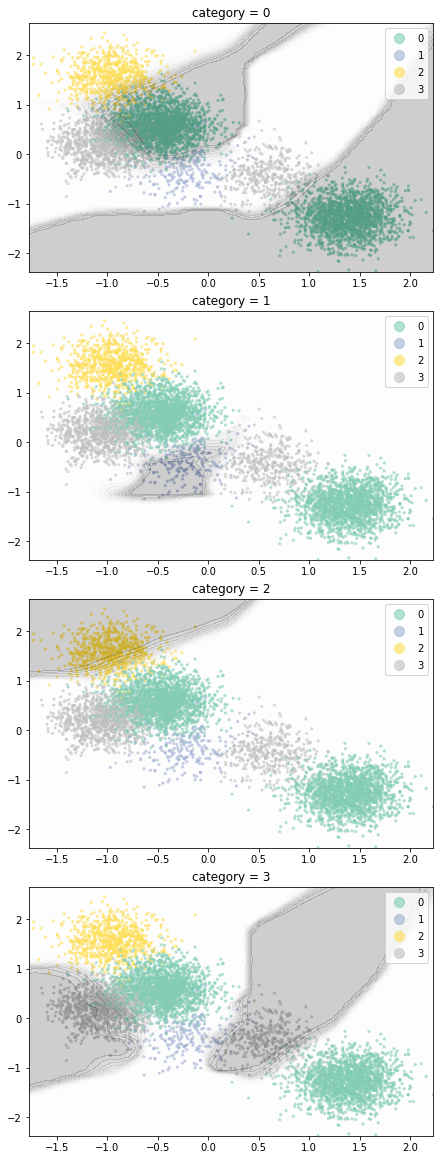

In [302]:
def plot_prediction_grid(model, 
                         X, y, 
                         n, 
                         cmap = 'Set2') -> None:
    
    categories = y_ordinal_encoder.categories_[0]
    n_categories = len(categories)
    
    X = X_standard_scaler.transform(X)
    y = y_ordinal_encoder.transform(y[:, None]).squeeze()
    
    def generate_grids(X, n):
        space_range = zip(
            np.min(X, axis = 0).tolist(), 
            np.max(X, axis = 0).tolist()
        )
        space = list(map(
            lambda x: np.linspace(*x, num = n), space_range
        ))
        meshgrid = np.meshgrid(*space)
        grid_flat = np.column_stack(
            list(map(lambda x: np.ravel(x), meshgrid))
        )   
        return meshgrid, grid_flat

    meshgrid, grid_flat = generate_grids(X, n)
    
    grid_tensor = grid_flat.astype(params['dtypes']['X'])
    grid_tensor = (
        torch.from_numpy(grid_tensor)
        .to(params['device'])
    )
    
    model.eval() 
    with torch.autograd.inference_mode(mode=True):
        grid_flat_pred = (
            model(grid_tensor)
            .softmax(1)
            .to(device = 'cpu')
        )

    
    fig, ax = plt.subplots(
        n_categories, 1, 
        figsize = (6, n_categories * 4), 
        constrained_layout = True
    )
    
    for i, category in enumerate(categories):
        category_prob = (
            grid_flat_pred[:, i]
            .reshape(meshgrid[0].shape)
        )
        
        p = ax[i].scatter(
            *X.T, 
            c=y, 
            alpha = 0.5,
            cmap=cmap, 
            s=5
        )
        _ = ax[i].legend(
            *p.legend_elements(prop='colors', size=10),
            bbox_to_anchor=(1,1)
        )
        _ = ax[i].contourf(
            *meshgrid, 
            category_prob, 
            alpha = 0.2, 
            cmap = 'Greys', 
            levels = 10
        )
        ax[i].set_title(f'category = {i}')

plot_prediction_grid(blobs_classifier, X_train, y_train, 50)